# KNN Shapley

This notebook shows how to calculate Shapley values for the K-Nearest Neighbours algorithm. By making use of the local structure of KNN, it is possible to compute an exact value in almost linear time, as opposed to exponential complexity of exact, model-agnostic Shapley.

The main idea is to exploit the fact that adding or removing points beyond the k-ball doesn't influence the score. Because the algorithm then essentially only needs to do a search it runs in $\mathcal{O}(N \log N)$ time.

By further using approximate nearest neighbours, it is possible to achieve $(\epsilon,\delta)$-approximations in sublinear time. However, this is not implemented in pyDVL yet.

We refer to the original paper that pyDVL implements for details: *Jia, Ruoxi, David Dao, Boxin Wang, Frances Ann Hubis, Nezihe Merve Gurel, Bo Li, Ce Zhang, Costas Spanos, and Dawn Song. [Efficient Task-Specific Data Valuation for Nearest Neighbor Algorithms](https://doi.org/10.14778/3342263.3342637). Proceedings of the VLDB Endowment 12, no. 11 (1 July 2019): 1610–23.*

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import random
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from copy import deepcopy
from notebook_support import plot_iris

plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

random_state = 24
random.seed(random_state)
np.random.seed(random_state)

The main entry point is the function [compute_shapley_values()](../pydvl/value/shapley/common.rst#pydvl.value.shapley.common.compute_shapley_values), which provides a facade to all Shapley methods. In order to use it we need the classes [Dataset](../pydvl/utils/dataset.rst#pydvl.utils.dataset.Dataset), [Utility](../pydvl/utils/utility.rst#pydvl.utils.utility.Utility) and [Scorer](../pydvl/utils/score.rst#pydvl.utils.score.Scorer), all of which can be imported from `pydvl.value`:

In [3]:
from pydvl.value import *

## Building a Dataset and a Utility

We use [the sklearn iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) and wrap it into a [pydvl.utils.dataset.Dataset](../pydvl/utils/dataset.rst#pydvl.utils.dataset.Dataset) calling the factory [pydvl.utils.dataset.Dataset.from_sklearn()](../pydvl/utils/dataset.rst#pydvl.utils.dataset.Dataset.from_sklearn). This automatically creates a train/test split for us which will be used to compute the utility.

We then create a model and instantiate a [Utility](../pydvl/utils/utility.rst#pydvl.utils.utility.Utility) using data and model. The model needs to implement the protocol [pydvl.utils.types.SupervisedModel](../pydvl/utils/types.rst#pydvl.utils.types.SupervisedModel), which is just the standard sklearn interface of `fit()`,`predict()` and `score()`. In constructing the `Utility` one can also choose a scoring function, but we pick the default which is just the model's `knn.score()`.

In [4]:
sklearn_dataset = sk.datasets.load_iris()
data = Dataset.from_sklearn(sklearn_dataset)
knn = sk.neighbors.KNeighborsClassifier(n_neighbors=5)
utility = Utility(knn, data)

## Computing values

Calculating the Shapley values is straightforward. We just call [compute_shapley_values()](../pydvl/value/shapley/common.rst#pydvl.value.shapley.common.compute_shapley_values) with the utility object we created above. The function returns a [ValuationResult](../pydvl/value/result.rst#pydvl.value.result.ValuationResult). This object contains the values themselves, data indices and labels.

In [5]:
shapley_values = compute_shapley_values(utility, mode=ShapleyMode.KNN, progress=True)
shapley_values.sort(key="value")
values = shapley_values.values

0it [00:00, ?it/s]

## Inspecting the results

Let us first look at the labels' distribution as a function of petal and sepal length:

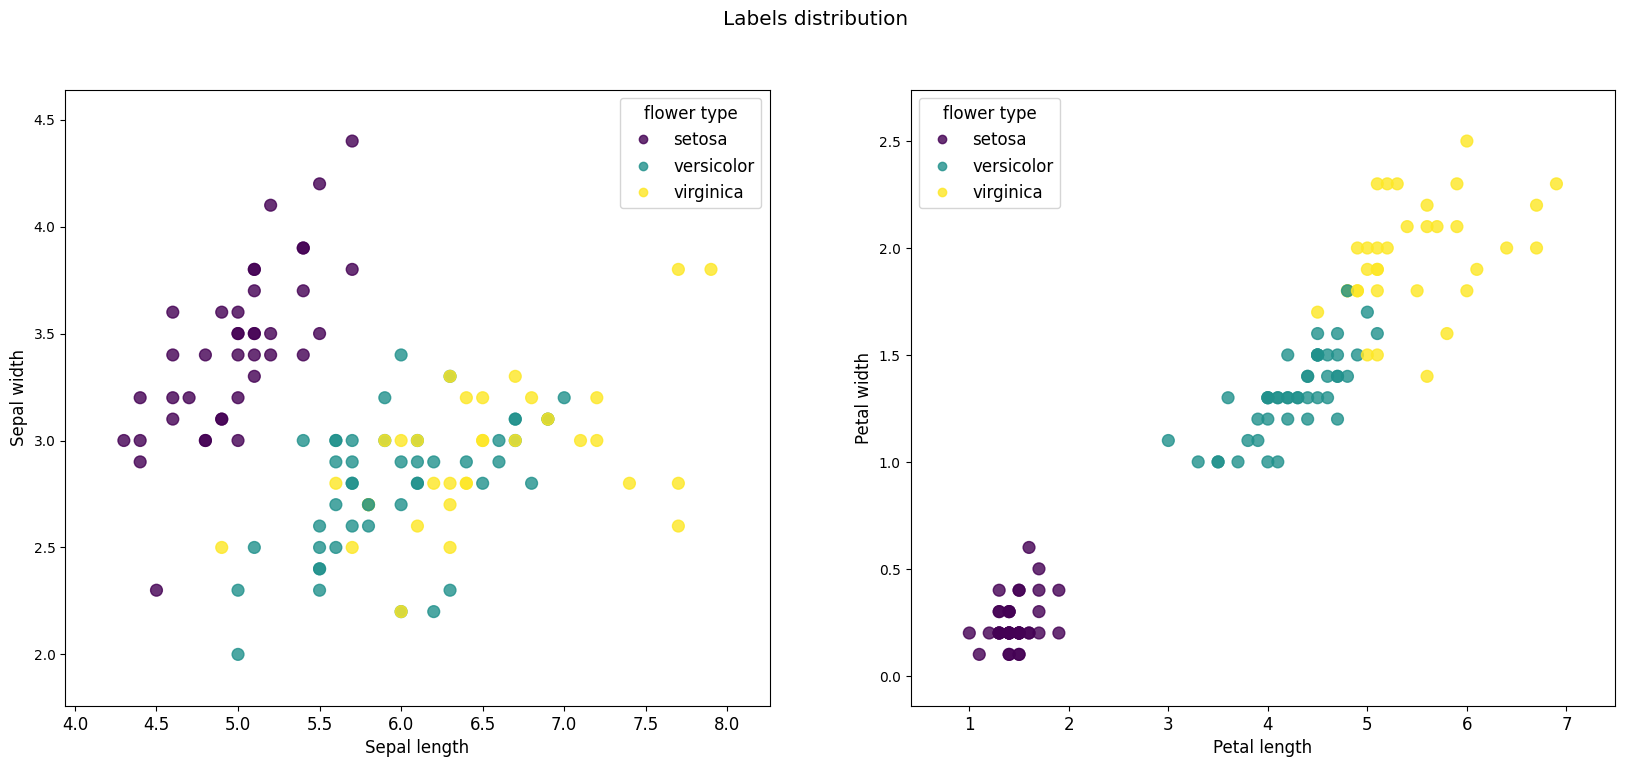

In [6]:
plot_iris(
    data,
    legend_title="flower type",
    legend_labels=list(sklearn_dataset.target_names),
    suptitle="Labels distribution",
    colorbar_limits=None,
)

If we now look at  the distribution of Shapley values for each class, we see that each has samples with both high and low scores. This is expected, because an accurate model uses information of all classes.

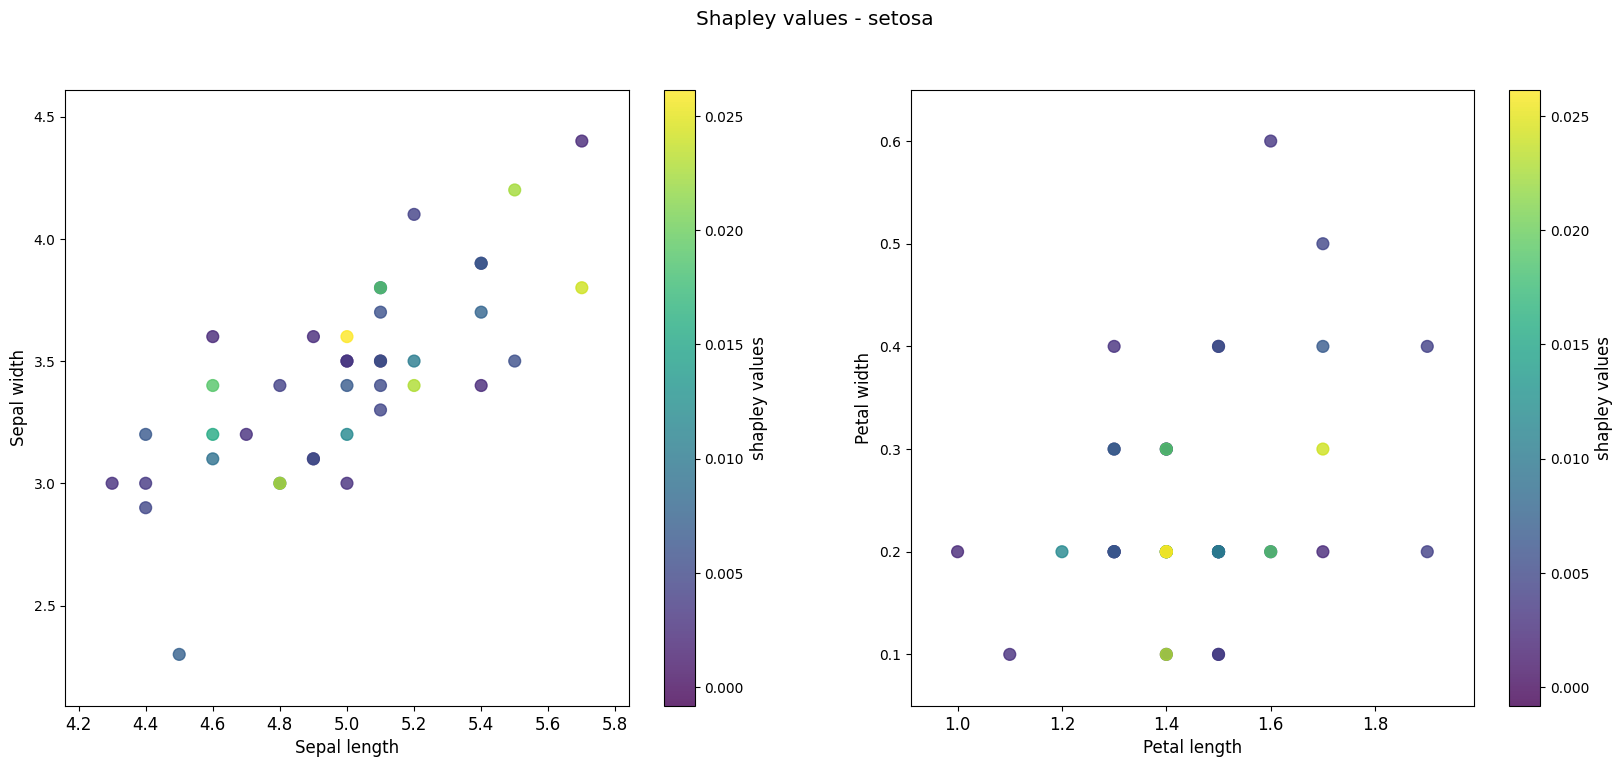

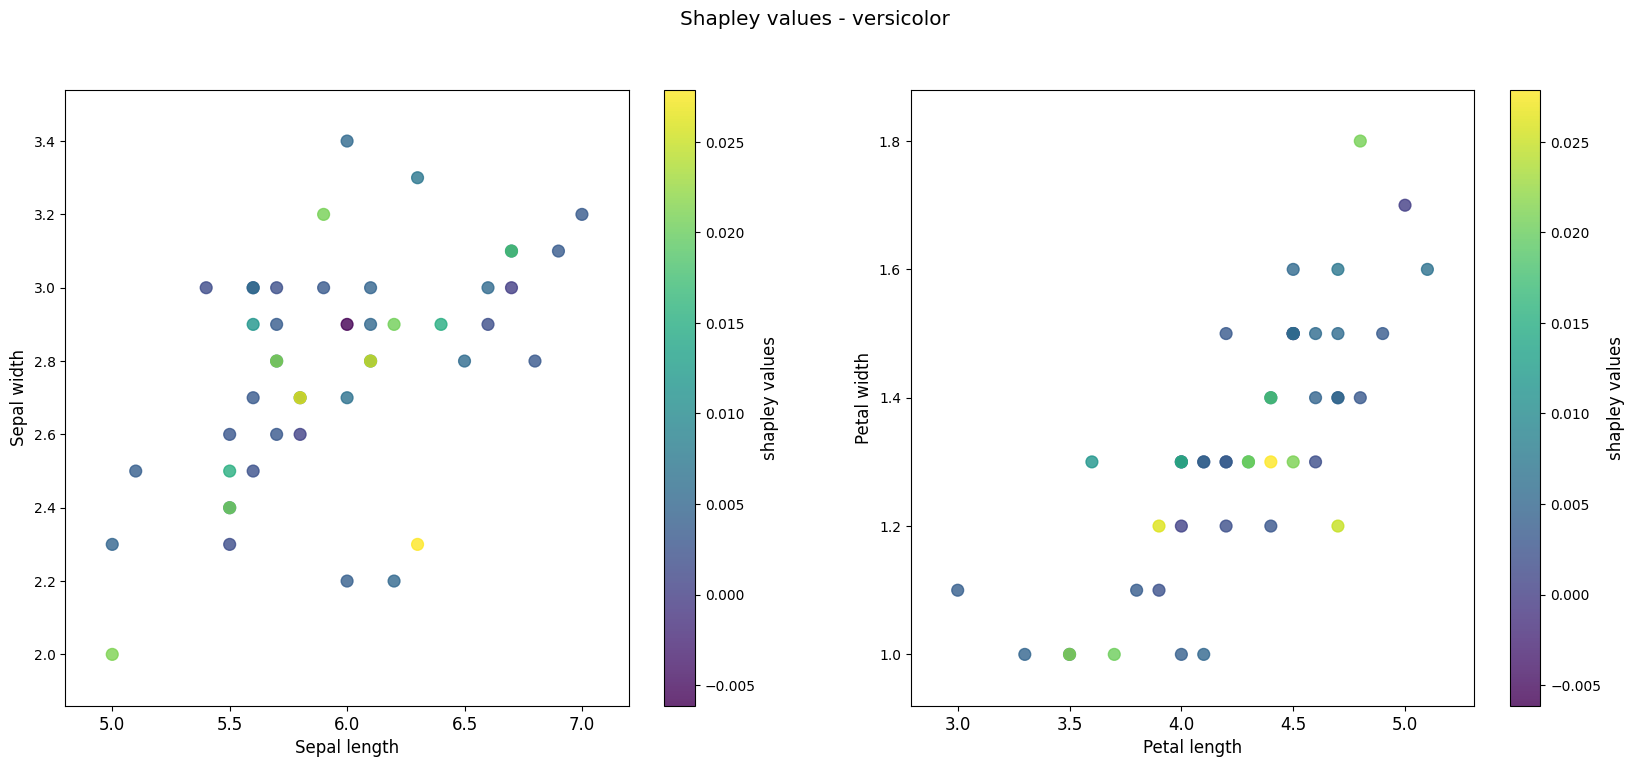

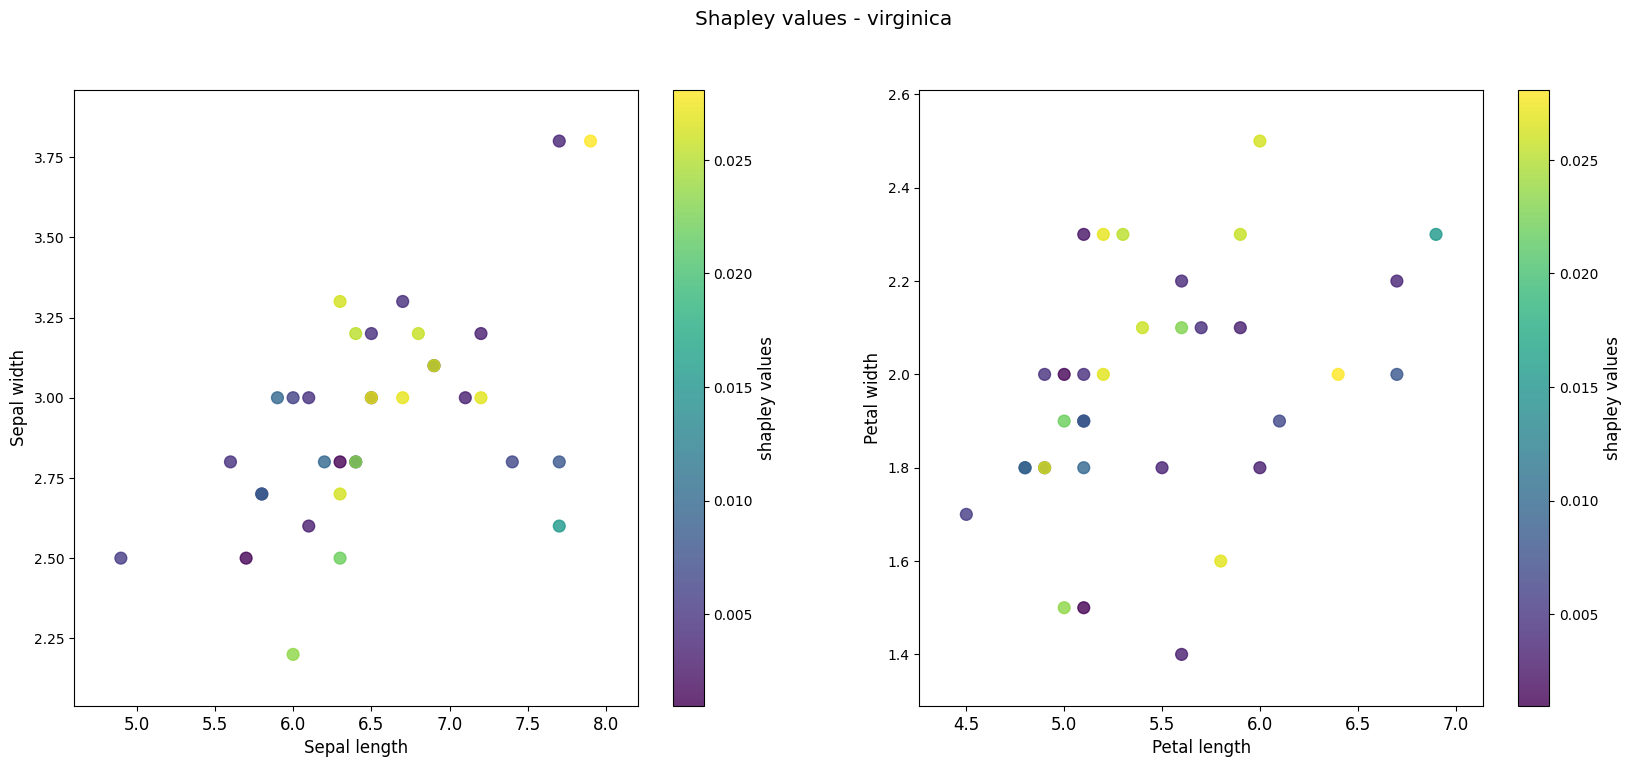

In [7]:
class_ids = np.unique(data.y_train)
for class_id in class_ids:
    class_idxs = np.array(
        [i for i, label in enumerate(data.y_train) if label == class_id]
    )
    plot_iris(
        data,
        indices=class_idxs,
        colors=values[class_idxs],
        legend_title="shapley values",
        suptitle=f"Shapley values - {sklearn_dataset.target_names[class_id]}",
    )

## Corrupting labels

To test how informative values are, we can corrupt some training labels and see how their Shapley values change with respect to the non-corrupted points.

In [8]:
corrupted_data = deepcopy(data)
n_corrupted = 10
corrupted_data.y_train[:n_corrupted] = (corrupted_data.y_train[:n_corrupted] + 1) % 3
knn = sk.neighbors.KNeighborsClassifier(n_neighbors=5)
contaminated_values = compute_shapley_values(
    Utility(knn, corrupted_data), mode=ShapleyMode.KNN
)

Taking the average corrupted value and comparing it to non-corrupted ones, we notice that on average anomalous points have a much lower score, i.e. they tend to be much less valuable to the model.

To do this, first we make sure that we access the results by data index with a call to `ValuationResult.sort()`, then we split the values into two groups: corrupted and non-corrupted. Note how we access property `values` of the `ValuationResult` object. This is a numpy array of values, sorted however the object was sorted. Finally, we compute the quantiles of the two groups and compare them. We see that the corrupted mean is in the lowest percentile of the value distribution, while the correct mean is in the 70th percentile.


In [9]:
contaminated_values.sort(
    key="index"
)  # This is redundant, but illustrates sorting, which is in-place

corrupted_shapley_values = contaminated_values.values[:n_corrupted]
correct_shapley_values = contaminated_values.values[n_corrupted:]

mean_corrupted = np.mean(corrupted_shapley_values)
mean_correct = np.mean(correct_shapley_values)
percentile_corrupted = np.round(100 * np.mean(values < mean_corrupted), 0)
percentile_correct = np.round(100 * np.mean(values < mean_correct), 0)

print(
    f"The corrupted mean is at percentile {percentile_corrupted:.0f} of the value distribution."
)
print(
    f"The correct mean is percentile {percentile_correct:.0f} of the value distribution."
)

The corrupted mean is at percentile 1 of the value distribution.
The correct mean is percentile 71 of the value distribution.


This is confirmed if we plot the distribution of Shapley values and circle corrupt points in red. They all tend to have low Shapley scores, regardless of their position in space and assigned label:

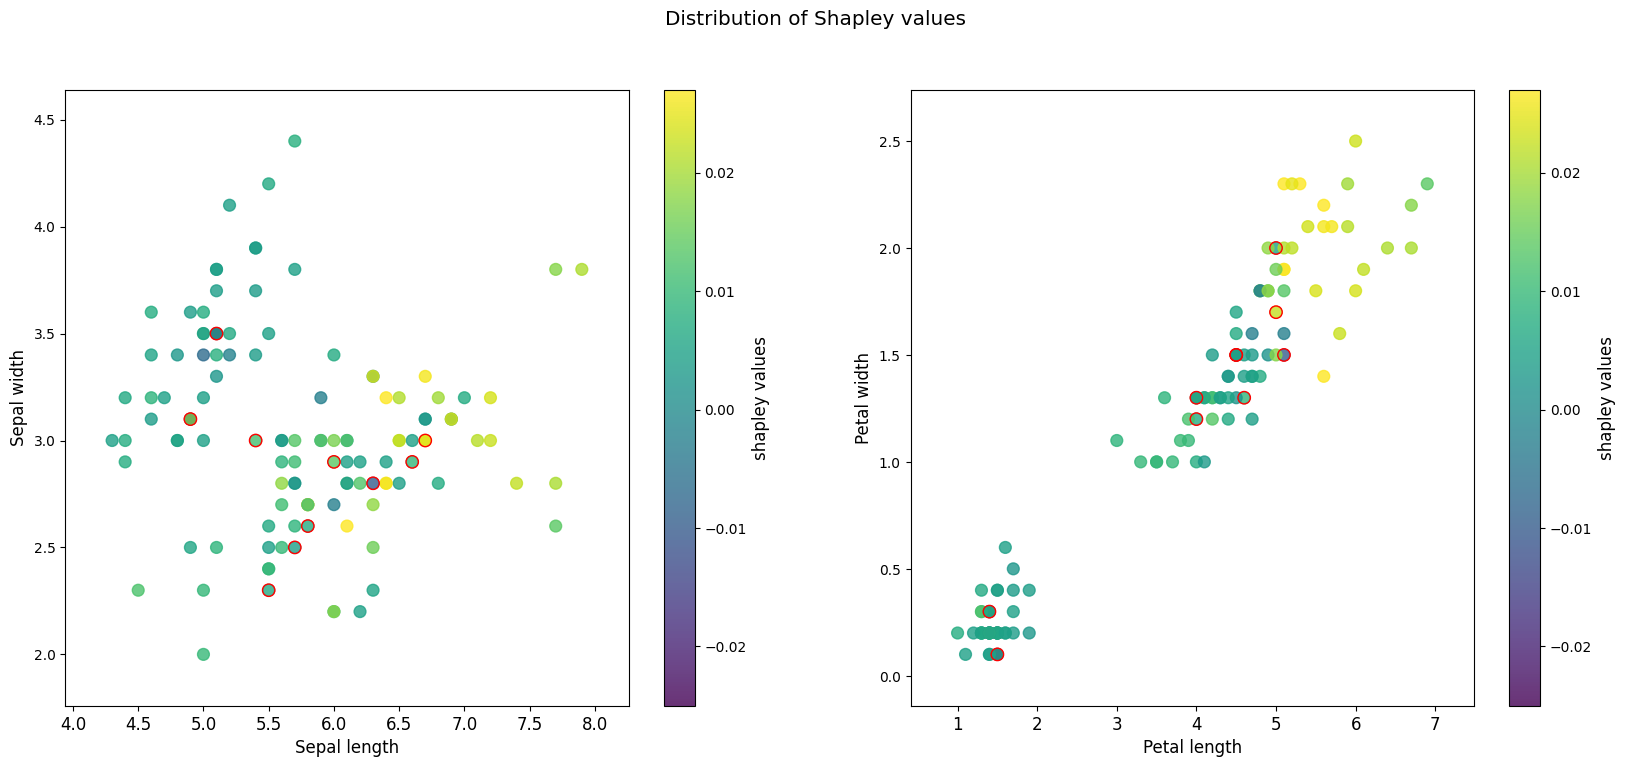

In [10]:
plot_iris(
    data,
    colors=contaminated_values.values,
    highlight_indices=np.arange(n_corrupted),
    legend_title="shapley values",
    suptitle="Distribution of Shapley values",
    colorbar_limits=(-0.025, 0.027),
)
